Install DGL

Import the necessary pacakges

In [1]:
import dgl
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt


**Q2**

import the karate dataset

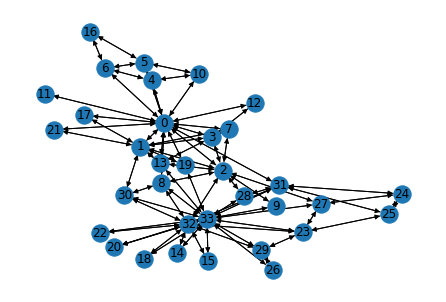

In [2]:
import dgl.data

dataset = dgl.data.KarateClubDataset()
g = dataset[0]
# type(g)
# nx.draw(g, with_labels=True)
nxg = dgl.to_networkx(g)
nx.draw(nxg, with_labels=True)

Preprocess the dataset

In [3]:
# Split edge set for training and testing
u, v = g.edges()

# Find all negative edges 
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the postive and negative graphes
pos_g = dgl.graph(
    (u, v), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [4]:
neg_g

Graph(num_nodes=34, num_edges=966,
      ndata_schemes={}
      edata_schemes={})

In [5]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2859,  0.1781],
        [ 0.1347, -0.1714],
        [ 0.2051, -0.1654],
        [-0.0232,  0.2284],
        [ 0.2250,  0.2930],
        [ 0.0884,  0.0381],
        [ 0.1765,  0.2515],
        [-0.3880,  0.1937],
        [-0.0366, -0.1109],
        [-0.1462,  0.3947],
        [ 0.2460,  0.3266],
        [ 0.2835,  0.3464],
        [ 0.0967,  0.1410],
        [ 0.3229,  0.3660],
        [ 0.3052,  0.2270],
        [-0.0621,  0.1500],
        [-0.3070, -0.0566],
        [-0.2665, -0.3914],
        [-0.4040,  0.4008],
        [-0.3900, -0.3951],
        [-0.2843,  0.3294],
        [-0.3131, -0.1229],
        [-0.3459, -0.0010],
        [-0.2538, -0.3053],
        [ 0.1851,  0.3586],
        [ 0.0183,  0.2016],
        [ 0.2979, -0.2961],
        [ 0.0162,  0.3249],
        [-0.0177,  0.3567],
        [ 0.3869, -0.1036],
        [-0.2941, -0.1221],
        [-0.2654, -0.3124],
        [-0.3892, -0.4038],
        [-0.2320, -0.3255]], requires_grad=True)

Build the model based on  GraphSAGE.





In [6]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the adjacency-based similarity loss

In [7]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [8]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))

      print()



In epoch 0, loss: 0.24692128598690033

In epoch 1, loss: 0.18470320105552673

In epoch 2, loss: 0.15213614702224731

In epoch 3, loss: 0.13681378960609436

In epoch 4, loss: 0.12976400554180145

In epoch 5, loss: 0.12652818858623505

In epoch 6, loss: 0.12490542978048325

In epoch 7, loss: 0.12413488328456879

In epoch 8, loss: 0.12360459566116333

In epoch 9, loss: 0.12328353524208069

In epoch 10, loss: 0.12309640645980835

In epoch 11, loss: 0.12299247831106186

In epoch 12, loss: 0.12293760478496552

In epoch 13, loss: 0.12290896475315094

In epoch 14, loss: 0.12289132177829742

In epoch 15, loss: 0.12287481129169464

In epoch 16, loss: 0.12285307794809341

In epoch 17, loss: 0.12282224744558334

In epoch 18, loss: 0.1227801963686943

In epoch 19, loss: 0.12272601574659348

In epoch 20, loss: 0.12265942245721817

In epoch 21, loss: 0.12258100509643555

In epoch 22, loss: 0.12249141186475754

In epoch 23, loss: 0.12239179760217667

In epoch 24, loss: 0.12228335440158844

In epoch 25

Draw the embedding

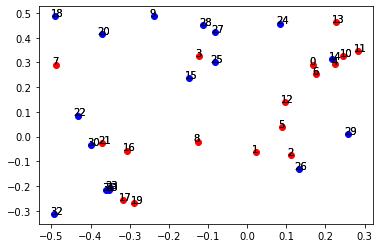

In [9]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

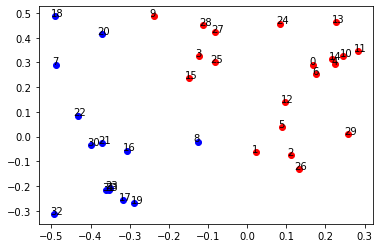

In [10]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

# Repeat the 3 steps above, but with 3 GNN layers and 2-hop similarity function.

You can modify the codes above.


Regenerate the training data that can be combined with the 2-hop similarity function. 

In [11]:
#obtain the two hop neighbor subgraph
sg,_ = dgl.khop_in_subgraph(g, 0, k=2)


node_id_map = {}
for i,org_id in enumerate(sg.ndata[dgl.NID]):
    node_id_map[i] = int(org_id.numpy())
    

###obtain the edges in original graph, as well as the edges in two hop neighbor subgraph.
u, v = g.edges()
u_s, v_s = sg.edges()

# Map the nodes with its original ID.
for j,uu in enumerate(u_s):
    u_s[j] = torch.tensor(node_id_map[int(uu.numpy())])

for j,vv in enumerate(v_s):
    v_s[j] = torch.tensor(node_id_map[int(vv.numpy())])


# Find all negative edges 
#(positive edge means the two nodes are connected in the two hop neighbors subgraph) 
adj = sp.coo_matrix((np.ones(len(u_s)), (u_s.numpy(), v_s.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

### build the positive and negative graph
pos_g = dgl.graph(
    (u_s, v_s), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [12]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.3396,  0.3910],
        [ 0.3329, -0.0190],
        [-0.0580,  0.0670],
        [-0.1811,  0.2583],
        [ 0.0315, -0.2563],
        [ 0.1817,  0.0719],
        [-0.3069, -0.3386],
        [ 0.0023, -0.3927],
        [ 0.0941, -0.3212],
        [-0.0470, -0.3670],
        [ 0.0490, -0.1085],
        [ 0.2165,  0.1229],
        [-0.3462, -0.2501],
        [ 0.3246, -0.2634],
        [-0.1948, -0.1983],
        [ 0.3628,  0.2316],
        [ 0.1200, -0.4058],
        [-0.1295,  0.0591],
        [-0.1855, -0.3315],
        [-0.3133,  0.1213],
        [ 0.0344,  0.3076],
        [-0.2342,  0.3860],
        [-0.1830, -0.3292],
        [ 0.0071, -0.1247],
        [-0.2806, -0.0334],
        [-0.1036, -0.3917],
        [-0.3577, -0.1026],
        [-0.3341,  0.3173],
        [-0.2005, -0.0979],
        [ 0.2099,  0.1358],
        [-0.3093,  0.3815],
        [ 0.2057,  0.1263],
        [ 0.2854, -0.0350],
        [ 0.2548,  0.2816]], requires_grad=True)

Build the model based on GraphSAGE.

In [13]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        
        self.gnn3 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        hidden2_ar = F.relu(hidden2)
        h = self.gnn3(g, hidden2_ar)
        return h

Define the two-hop similarity loss.

In [14]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [15]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))



In epoch 0, loss: 0.6548792719841003
In epoch 1, loss: 0.4065757989883423
In epoch 2, loss: 0.26514482498168945
In epoch 3, loss: 0.18464720249176025
In epoch 4, loss: 0.1373407393693924
In epoch 5, loss: 0.11406788975000381
In epoch 6, loss: 0.10346346348524094
In epoch 7, loss: 0.09954957664012909
In epoch 8, loss: 0.09868117421865463
In epoch 9, loss: 0.0992027223110199
In epoch 10, loss: 0.10027822852134705
In epoch 11, loss: 0.10139541327953339
In epoch 12, loss: 0.10234120488166809
In epoch 13, loss: 0.10298510640859604
In epoch 14, loss: 0.10331673920154572
In epoch 15, loss: 0.103569895029068
In epoch 16, loss: 0.1036820188164711
In epoch 17, loss: 0.1036570742726326
In epoch 18, loss: 0.1035129651427269
In epoch 19, loss: 0.10325034707784653
In epoch 20, loss: 0.10287848860025406
In epoch 21, loss: 0.10245378315448761
In epoch 22, loss: 0.1019914448261261
In epoch 23, loss: 0.10149987041950226
In epoch 24, loss: 0.10098636150360107
In epoch 25, loss: 0.10045736283063889
In epo


Draw the embedding

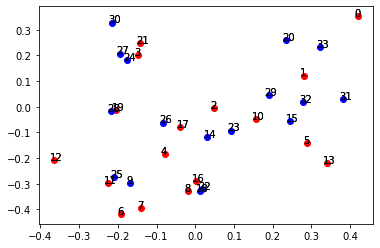

In [16]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

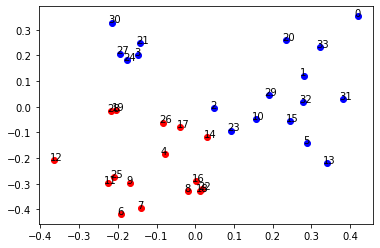

In [17]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

**Q3**
Node Classfication


import the Cora dataset

In [18]:
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
g_number_of_nodes = g.number_of_nodes()
g_numb_feats = g.ndata['feat'].shape[1]

Extracting file to C:\Users\kkaus\.dgl\cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Build the model based on  GraphSAGE.


In [19]:
'''please build the model'''
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build GraphSAGE layer '''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        h = F.relu(hidden2)
        return h

Define the linear classifier

In [20]:
'''please build the classifier'''
class Classifier(nn.Module):
    def __init__(self, h_feat, num_classes):
        super(Classifier, self).__init__()
        '''please build the linear classfier '''
        self.fc1 = nn.Linear( 
            in_features = h_feat,
            out_features = num_classes)

    def forward(self, in_feat):
        h = self.fc1(in_feat)
        return h

In [21]:
input = g.ndata['feat']
print(input)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Train the NN.

In [22]:

    h_feats = 16
    num_classes = 7
    input_feats = g.ndata['feat'].shape[1]
    g_number_of_nodes = g.number_of_nodes()
    input = g.ndata['feat']

    import itertools
    '''please complete the functions for the  model'''
    classifier = Classifier(h_feats, num_classes)
    model = Model(input_feats, h_feats)
    optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), classifier.parameters()), lr=0.01)

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]

    best_val_acc = 0.0
    best_test_acc = 0.0

    for e in range(100):
        '''please fill in the missing "Forward" and "Compute loss" in training process'''
        # Forward
        hidden = model(g, input)
        logits = classifier(hidden)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc





        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}".format(
                    e, loss, val_acc, test_acc
                )
            )

In epoch 0, loss: 1.956, val acc: 0.316, test acc: 0.319
In epoch 1, loss: 1.945, val acc: 0.316, test acc: 0.319
In epoch 2, loss: 1.931, val acc: 0.316, test acc: 0.319
In epoch 3, loss: 1.914, val acc: 0.316, test acc: 0.322
In epoch 4, loss: 1.892, val acc: 0.344, test acc: 0.354
In epoch 5, loss: 1.865, val acc: 0.488, test acc: 0.452
In epoch 6, loss: 1.835, val acc: 0.350, test acc: 0.330
In epoch 7, loss: 1.801, val acc: 0.230, test acc: 0.232
In epoch 8, loss: 1.760, val acc: 0.200, test acc: 0.225
In epoch 9, loss: 1.715, val acc: 0.196, test acc: 0.220
In epoch 10, loss: 1.664, val acc: 0.210, test acc: 0.229
In epoch 11, loss: 1.608, val acc: 0.222, test acc: 0.237
In epoch 12, loss: 1.545, val acc: 0.230, test acc: 0.244
In epoch 13, loss: 1.477, val acc: 0.242, test acc: 0.255
In epoch 14, loss: 1.402, val acc: 0.258, test acc: 0.271
In epoch 15, loss: 1.322, val acc: 0.260, test acc: 0.282
In epoch 16, loss: 1.239, val acc: 0.274, test acc: 0.302
In epoch 17, loss: 1.153